In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd

from os import listdir
from os.path import isfile, join

import shutil

import seaborn as sns

from sklearn.metrics import confusion_matrix

import shap

%matplotlib inline

<AxesSubplot:>

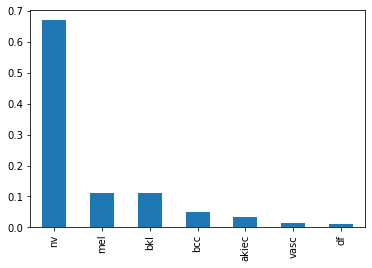

In [2]:
df = pd.read_csv('data/HAM10000_metadata.csv')
df.head()

filtered = df.iloc[list(range(0, len(df), 2)),:].copy().reset_index(drop = True)
filtered.head()

filtered['dx'].value_counts(normalize = True).plot(kind = 'bar')

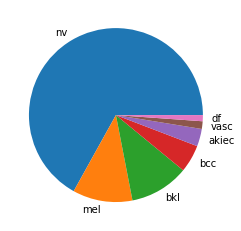

In [3]:
filtered['dx'].value_counts(normalize = True).plot(kind = 'pie')
plt.ylabel(None)
plt.show()

In [4]:
label_encoding = sorted(list(filtered['dx'].unique()))
label_encoding

#############Enablefor mving files #################

# image_labels = dict(zip(filtered['image_id'], filtered['dx']))

# train_path = 'data/all_images'
# onlyfiles = [f for f in listdir(train_path) if isfile(join(train_path, f))]

# for i in filtered['image_id']:
#     source = train_path + "/" + i + '.jpg'
#     dest = train_path + "/" + image_labels[i] + "/" + i + '.jpg'
# #     print(source)
# #     print(dest)
#     shutil.copy(source, dest)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [5]:
# Load training and validation sets

# prefetches images
# keep the images for training ready. 
# when one batch is being used for training

ds_train_ = image_dataset_from_directory(
    'data/all_images',
    labels='inferred',
    label_mode='categorical',
    image_size=[600, 450],
    interpolation='nearest',
    batch_size=4,
    shuffle=True,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'training',
    seed = 2
)
ds_valid_ = image_dataset_from_directory(
    'data/all_images',
    labels='inferred',
    label_mode='categorical',
    image_size=[600, 450],
    interpolation='nearest',
    batch_size=4,
    shuffle=True,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'validation',
    seed = 2
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5008 files belonging to 7 classes.
Using 4007 files for training.
Found 5008 files belonging to 7 classes.
Using 1001 files for validation.


# Data Augmentation (To be explored later)

In [6]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    # preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    # preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    # preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    # preprocessing.RandomRotation(factor=0.20),
    # preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

# NN

## NN creation

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    #input image
    layers.InputLayer(input_shape=[600, 450, 3]),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
     # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
    # Block four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Flattening back to "1D"
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),
    
    #output
    layers.Dense(7, activation='softmax'),
])

optimizer = tf.keras.optimizers.Adam(epsilon = 0.01)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 600, 450, 3)       21        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 596, 446, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 298, 223, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 298, 223, 32)      224       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 294, 219, 32)      25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 147, 109, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 147, 109, 32)     

In [12]:
tf.device("/gpu:0")

In [13]:
save = 0

In [14]:
if save == 1:
    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=1,
        use_multiprocessing=True,
    )
    model.save_weights('model1')
else:
    model.load_weights('model1')

In [110]:
history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=1,
        use_multiprocessing=True,
    )

Train on 1002 steps, validate on 251 steps
1002/1002 [==============================] - 1438s 1s/step - batch: 500.5000 - size: 1.0000 - loss: 1.1962 - categorical_accuracy: 0.6681 - val_loss: 1.1517 - val_categorical_accuracy: 0.6683


In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

In [11]:
predictions = np.array([])
labels =  np.array([])
for x, y in ds_train:
    predict_x=model.predict(x) 
    classes_x=np.argmax(predict_x,axis=1)
    predictions = np.concatenate([predictions, classes_x])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

confusion_matrix(y_true=labels, y_pred=predictions)

array([[   5,    9,   35,    3,    1,   71,    3],
       [   1,   33,   48,    2,    1,  122,    1],
       [   2,    4,  125,    1,    1,  313,    1],
       [   0,    7,   13,    3,    0,   22,    0],
       [   0,    2,   30,    0,    5,  402,    3],
       [   0,   20,   67,    2,    1, 2593,    0],
       [   3,    0,    4,    0,    2,   44,    2]], dtype=int64)

<AxesSubplot:>

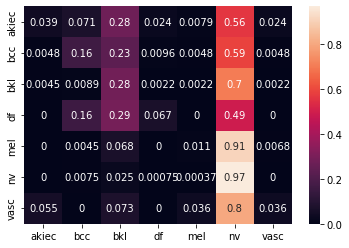

In [12]:
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predictions, normalize = 'true'),
             columns = label_encoding,
             index = label_encoding,)
sns.heatmap(df, annot = True)

In [13]:
predictions = np.array([])
labels =  np.array([])
for x, y in ds_valid:
    predict_x=model.predict(x) 
    classes_x=np.argmax(predict_x,axis=1)
    predictions = np.concatenate([predictions, classes_x])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

confusion_matrix(y_true=labels, y_pred=predictions)

array([[  0,   2,  10,   0,   2,  22,   0],
       [  1,   5,  12,   0,   1,  29,   1],
       [  0,   1,  32,   0,   0,  71,   0],
       [  0,   1,   3,   0,   0,   8,   0],
       [  0,   0,  10,   0,   0, 103,   2],
       [  1,   7,  17,   0,   1, 643,   0],
       [  0,   2,   2,   0,   0,  10,   2]], dtype=int64)

<AxesSubplot:>

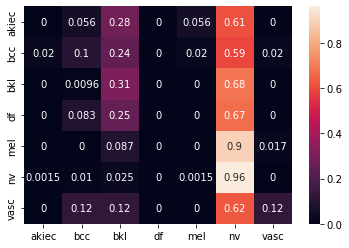

In [14]:
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predictions, normalize = 'true'),
             columns = label_encoding,
             index = label_encoding,)
sns.heatmap(df, annot = True)

In [32]:
model2 = keras.Sequential([
    layers.InputLayer(input_shape=[600, 450, 3]),
    
    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
    # Block four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),
    layers.Dense(7, activation='softmax'),
])

optimizer = tf.keras.optimizers.Adam(epsilon = 0.01)
model2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 600, 450, 3)       21        
_________________________________________________________________
conv2d (Conv2D)              (None, 596, 446, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 298, 223, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 298, 223, 32)      224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 294, 219, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 147, 109, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 147, 109, 32)      2

In [33]:
class_weights = {
    0 : 1,
    1 : 1,
    2 : 1,
    3 : 1,
    4 : 5,
    5 : 1,
    6 : 1,
}

In [34]:
save = 1

In [35]:
if save == 1:
    history = model2.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=1,
        use_multiprocessing=True,
        class_weight = class_weights
    )
    model2.save_weights('model2')
else:
    model2.load_weights('model2')

501/501 [==============================] - 254s 501ms/step - loss: 2.0628 - categorical_accuracy: 0.4866 - val_loss: 1.1932 - val_categorical_accuracy: 0.4765


In [36]:
predictions = np.array([])
labels =  np.array([])
for x, y in ds_train:
    predict_x=model2.predict(x) 
    classes_x=np.argmax(predict_x,axis=1)
    predictions = np.concatenate([predictions, classes_x])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

confusion_matrix(y_true=labels, y_pred=predictions)

array([[   1,   12,    1,    0,   63,   50,    0],
       [   1,   28,    0,    1,  100,   77,    1],
       [   1,   18,   13,    4,  303,  108,    0],
       [   0,    5,    2,    0,   17,   21,    0],
       [   1,    1,    1,    0,  413,   26,    0],
       [   3,   18,    9,   10, 1117, 1491,   35],
       [   0,    2,    1,    1,   25,   17,    9]], dtype=int64)

<AxesSubplot:>

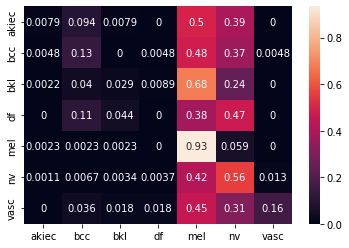

In [37]:
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predictions, normalize = 'true'),
             columns = label_encoding,
             index = label_encoding,)
sns.heatmap(df, annot = True)

In [38]:
predictions = np.array([])
labels =  np.array([])
for x, y in ds_valid:
    predict_x=model2.predict(x) 
    classes_x=np.argmax(predict_x,axis=1)
    predictions = np.concatenate([predictions, classes_x])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

confusion_matrix(y_true=labels, y_pred=predictions)

array([[  0,   4,   0,   0,  17,  15,   0],
       [  0,   5,   1,   0,  24,  19,   0],
       [  0,   5,   0,   0,  68,  31,   0],
       [  0,   2,   0,   1,   4,   5,   0],
       [  0,   0,   0,   0, 104,  11,   0],
       [  1,   5,   3,   0, 290, 366,   4],
       [  0,   0,   0,   0,   8,   7,   1]], dtype=int64)

<AxesSubplot:>

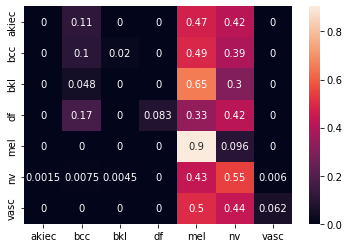

In [39]:
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predictions, normalize = 'true'),
             columns = label_encoding,
             index = label_encoding,)
sns.heatmap(df, annot = True)

In [14]:
keras.backend.clear_session()

# binary classification

In [15]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'data/binary_class',
    labels='inferred',
    label_mode='binary',
    image_size=[600, 450],
    interpolation='nearest',
    batch_size=8,
    shuffle=True,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'training',
    seed = 1
)
ds_valid_ = image_dataset_from_directory(
    'data/binary_class',
    labels='inferred',
    label_mode='binary',
    image_size=[600, 450],
    interpolation='nearest',
    batch_size=8,
    shuffle=True,
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'validation',
    seed = 1
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5008 files belonging to 2 classes.
Using 4007 files for training.
Found 5008 files belonging to 2 classes.
Using 1001 files for validation.


In [17]:
model3 = keras.Sequential([
    layers.InputLayer(input_shape=[600, 450, 3]),
    
    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
    # Block four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),
    
    # output
    layers.Dense(1, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(epsilon = 0.01)
model3.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 600, 450, 3)       21        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 596, 446, 32)      2432      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 298, 223, 32)      0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 298, 223, 32)      224       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 294, 219, 32)      25632     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 147, 109, 32)      0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 147, 109, 32)     

In [18]:
class_weights = {
    0 : 1,
    1 : 7
}

In [9]:
save = 0

In [19]:
if save == 1:
    history = model3.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=2,
        use_multiprocessing=True,
        class_weight = class_weights)
    model3.save_weights('model3')
else:
    model3.load_weights('model3')

In [46]:
predictions = []
labels =  []
for x, y in ds_train:
    predictions = predictions + model3.predict(x).tolist()
    labels = labels + y.numpy().tolist()

In [47]:
predictions = [x[0] for x in predictions]
labels = [x[0] for x in labels]

In [48]:
temp = pd.DataFrame({
    'prob' : predictions,
    'label':labels
})

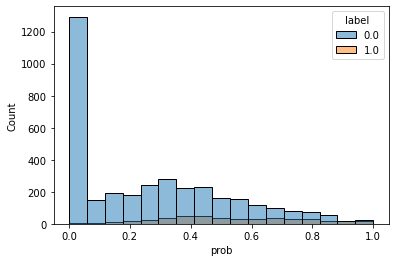

In [49]:
sns.histplot(data = temp, x = 'prob', hue = 'label')
plt.show()

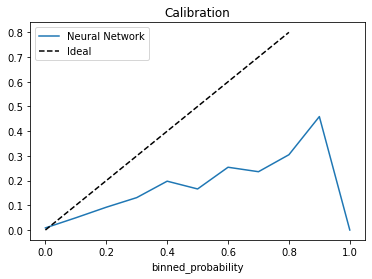

In [50]:
nbins = 10
bins = list(range(0, 100, int(100 / nbins)))
bins = [b/100 for b in bins]

def create_bins(p):
    for i in range(nbins):
        if i == nbins - 1:
            if (p > bins[i]) and (p < 1):
                return bins[i]
            else:
                return 1
        if (p > bins[i]) and (p < bins[i+1]):
            return bins[i]
    return 0

temp['binned_probability'] = temp['prob'].apply(create_bins)
temp.groupby('binned_probability')['label'].mean().plot(label = 'Neural Network')
plt.plot([0, 0.8] , [0, 0.8], 'k--',label = 'Ideal')
plt.title("Calibration")
plt.legend()
plt.show()

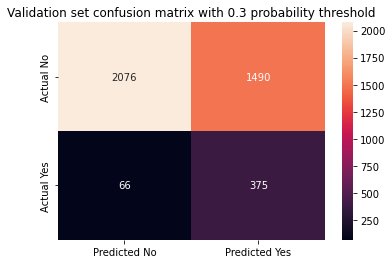

In [51]:
predicted_class = [1 if p > 0.3 else 0 for p in predictions]
confusion_matrix(y_true=labels, y_pred=predicted_class)
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predicted_class),
             columns = ['Predicted No', 'Predicted Yes'],
             index = ['Actual No', 'Actual Yes'],)
sns.heatmap(df, annot = True, fmt = 'd')
plt.title("Validation set confusion matrix with 0.3 probability threshold")
plt.show()

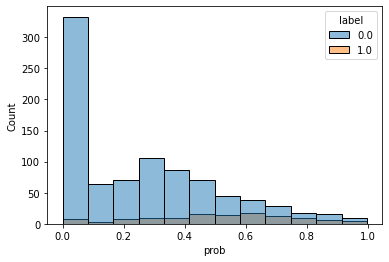

In [52]:
predictions = []
labels =  []
for x, y in ds_valid:
    predictions = predictions + model3.predict(x).tolist()
    labels = labels + y.numpy().tolist()
predictions = [x[0] for x in predictions]
labels = [x[0] for x in labels]
temp = pd.DataFrame({
    'prob' : predictions,
    'label':labels
})
sns.histplot(data = temp, x = 'prob', hue = 'label')
plt.show()

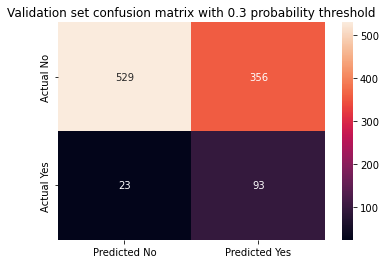

In [53]:
predicted_class = [1 if p > 0.3 else 0 for p in predictions]
confusion_matrix(y_true=labels, y_pred=predicted_class)
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predicted_class),
             columns = ['Predicted No', 'Predicted Yes'],
             index = ['Actual No', 'Actual Yes'],)
sns.heatmap(df, annot = True, fmt = 'd')
plt.title("Validation set confusion matrix with 0.3 probability threshold")
plt.show()

In [7]:
model4 = keras.Sequential([
    layers.InputLayer(input_shape=[600, 450, 3]),
    
    # Block One
    # layers.BatchNormalization(renorm=True),
#     layers.Rescaling(scale = 1./255),
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=9, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=7, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
    # Block Four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
    # Block four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),
    
    # output
    layers.Dense(1, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model4.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 600, 450, 3)       21        
_________________________________________________________________
conv2d (Conv2D)              (None, 592, 442, 32)      7808      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 296, 221, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 296, 221, 32)      224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 290, 215, 32)      50208     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 145, 107, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 145, 107, 32)      2

In [8]:
save = 1

In [10]:
if save == 1:
    history = model4.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=1,
        use_multiprocessing=True,
        class_weight = {0:1, 1:7}
    )
    model4.save_weights('model4')
else:
    model4.load_weights('model4')


501/501 [==============================] - 381s 760ms/step - loss: 0.9382 - accuracy: 0.6571 - val_loss: 0.7082 - val_accuracy: 0.5315


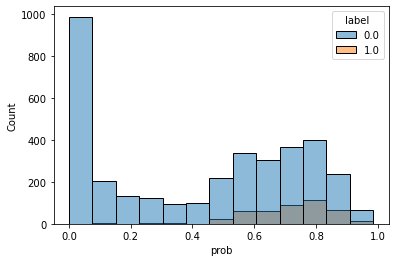

In [11]:
predictions = []
labels =  []
for x, y in ds_train:
    predictions = predictions + model4.predict(x).tolist()
    labels = labels + y.numpy().tolist()
    
predictions = [x[0] for x in predictions]
labels = [x[0] for x in labels]

temp = pd.DataFrame({
    'prob' : predictions,
    'label':labels
})

sns.histplot(data = temp, x = 'prob', hue = 'label')
plt.show()

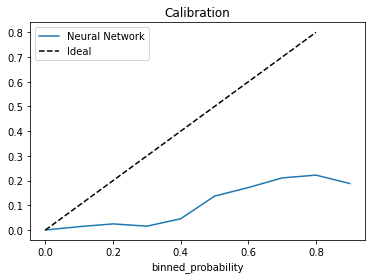

In [12]:
nbins = 10
bins = list(range(0, 100, int(100 / nbins)))
bins = [b/100 for b in bins]

def create_bins(p):
    for i in range(nbins):
        if i == nbins - 1:
            if (p > bins[i]) and (p < 1):
                return bins[i]
            else:
                return 1
        if (p > bins[i]) and (p < bins[i+1]):
            return bins[i]
    return 0

temp['binned_probability'] = temp['prob'].apply(create_bins)
temp.groupby('binned_probability')['label'].mean().plot(label = 'Neural Network')
plt.plot([0, 0.8] , [0, 0.8], 'k--',label = 'Ideal')
plt.title("Calibration")
plt.legend()
plt.show()

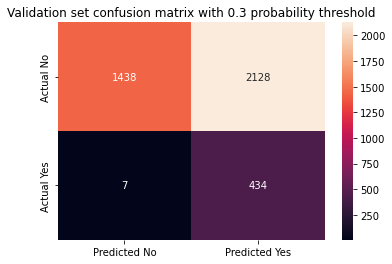

In [13]:
predicted_class = [1 if p > 0.3 else 0 for p in predictions]
confusion_matrix(y_true=labels, y_pred=predicted_class)
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predicted_class),
             columns = ['Predicted No', 'Predicted Yes'],
             index = ['Actual No', 'Actual Yes'],)
sns.heatmap(df, annot = True, fmt = 'd')
plt.title("Validation set confusion matrix with 0.3 probability threshold")
plt.show()

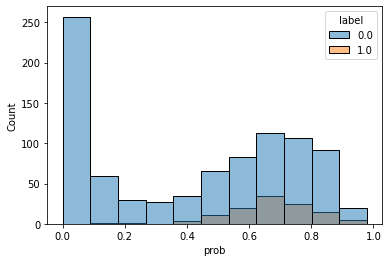

In [14]:
predictions = []
labels =  []
for x, y in ds_valid:
    predictions = predictions + model4.predict(x).tolist()
    labels = labels + y.numpy().tolist()
    
predictions = [x[0] for x in predictions]
labels = [x[0] for x in labels]

temp = pd.DataFrame({
    'prob' : predictions,
    'label':labels
})

sns.histplot(data = temp, x = 'prob', hue = 'label')
plt.show()

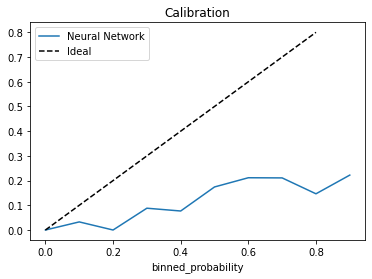

In [15]:
nbins = 10
bins = list(range(0, 100, int(100 / nbins)))
bins = [b/100 for b in bins]

def create_bins(p):
    for i in range(nbins):
        if i == nbins - 1:
            if (p > bins[i]) and (p < 1):
                return bins[i]
            else:
                return 1
        if (p > bins[i]) and (p < bins[i+1]):
            return bins[i]
    return 0

temp['binned_probability'] = temp['prob'].apply(create_bins)
temp.groupby('binned_probability')['label'].mean().plot(label = 'Neural Network')
plt.plot([0, 0.8] , [0, 0.8], 'k--',label = 'Ideal')
plt.title("Calibration")
plt.legend()
plt.show()

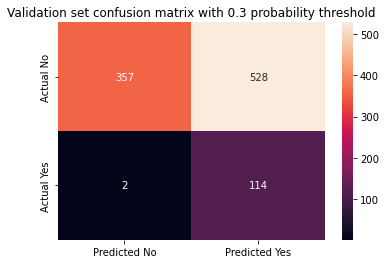

In [16]:
predicted_class = [1 if p > 0.3 else 0 for p in predictions]
confusion_matrix(y_true=labels, y_pred=predicted_class)
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predicted_class),
             columns = ['Predicted No', 'Predicted Yes'],
             index = ['Actual No', 'Actual Yes'],)
sns.heatmap(df, annot = True, fmt = 'd')
plt.title("Validation set confusion matrix with 0.3 probability threshold")
plt.show()

In [29]:
keras.backend.clear_session()